<a href="https://colab.research.google.com/github/balajikatyan/Bitcoin_Prediction/blob/main/10_Time_Series_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###What are we going to cover

* Get time series data (the historical price of Bitcoin)
* Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
* Creating training and test sets (the wrong way)
* Creating training and test sets (the right way)
* Visualizing time series data
* Turning time series data into a supervised learning problem (windowing)
* Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
* Dense (fully-connected) networks
* Sequence models (LSTM and 1D CNN)
* Ensembling (combining multiple models together)
* Multivariate models
* Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)

In [1]:
!nvidia-smi

Wed Mar 26 19:16:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

###Get Data

In [2]:
#Download Bitcoin historical data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2025-03-26 19:16:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2025-03-26 19:16:30 (52.0 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



###Importing time series data with pandas


In [3]:
#Import with pandas
import pandas as pd

#Parse dates and set date column to in
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


##Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

In [5]:
#How many samples do we have
print(len(df))
print(2787/365)

2787
7.635616438356164


#We've collected the histoircal price for the past ~8 years


In [6]:
#Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"].rename({"CLosing Price (USD)": "Price"}))
bitcoin_prices.head()

,Closing Price (USD)
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


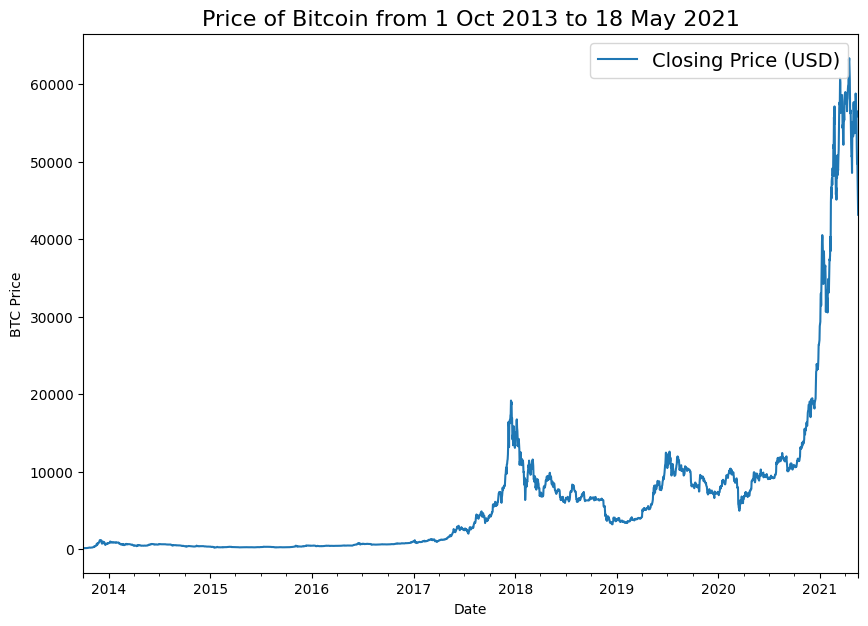

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

###Importing time series Data using CSV MOdule
If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's in-built csv module. And if you're working with dates, you might also want to use Python's datetime.

Let's see how we can replicate the plot we created before except this time using Python's csv and datetime modules.

In [8]:
#Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",") #Read in the target csv
  next(csv_reader) #Skip first line(this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))#get the dates as datetime
    btc_price.append(float(line[2])) #get the closing price as float

#View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

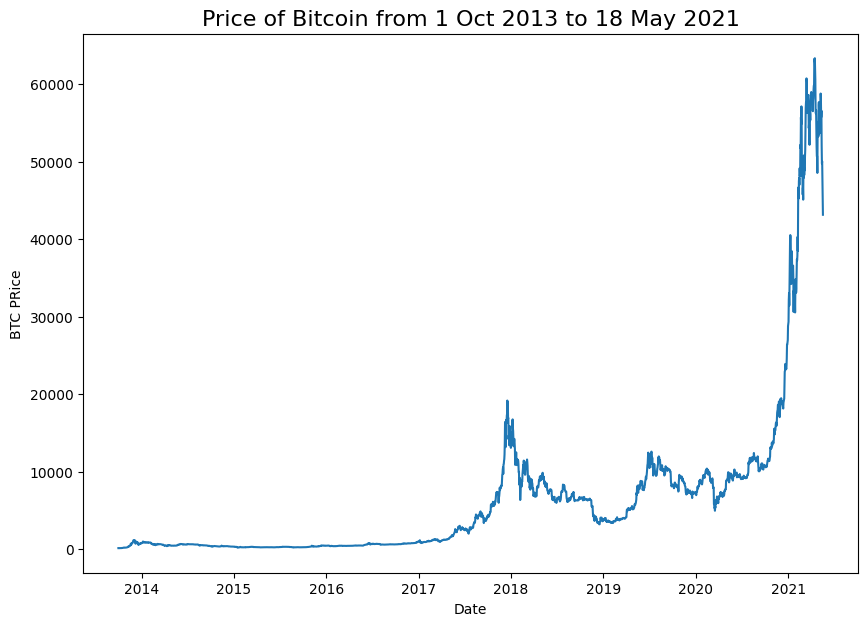

In [9]:
#Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC PRice");


#Format Data Part 1: Creating train and test sets for time series data

In [10]:
#Get Bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
price = bitcoin_prices.to_numpy()
timesteps[:10], btc_price[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [11]:
#Wrong way to make train/test sets for timeseries sets for time series
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test= train_test_split(timesteps,
                                                     price,
                                                     test_size=0.2,
                                                     random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229, 1), (558, 1))

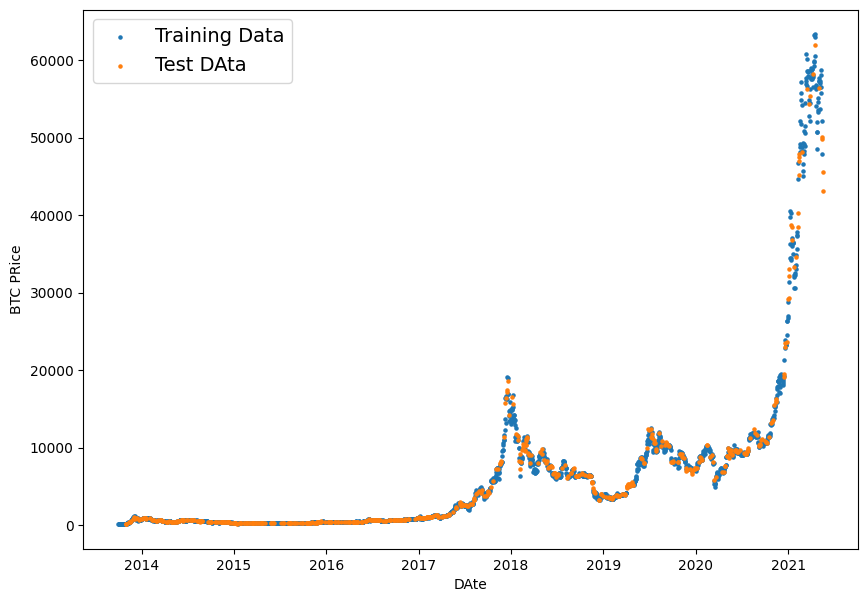

In [12]:
#Let's plot the wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Training Data")
plt.scatter(X_test, y_test, s=5, label="Test DAta")
plt.xlabel("DAte")
plt.ylabel("BTC PRice")
plt.legend(fontsize=14)
plt.show();

In [13]:
#Create train and test splits the right way for the time series
split_size = int(0.8* len(btc_price)) #80% train, 20%test

#Create train data splits(everything before the split)
X_train, y_train = timesteps[:split_size], price[:split_size]

#Create test data splits(everything after the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

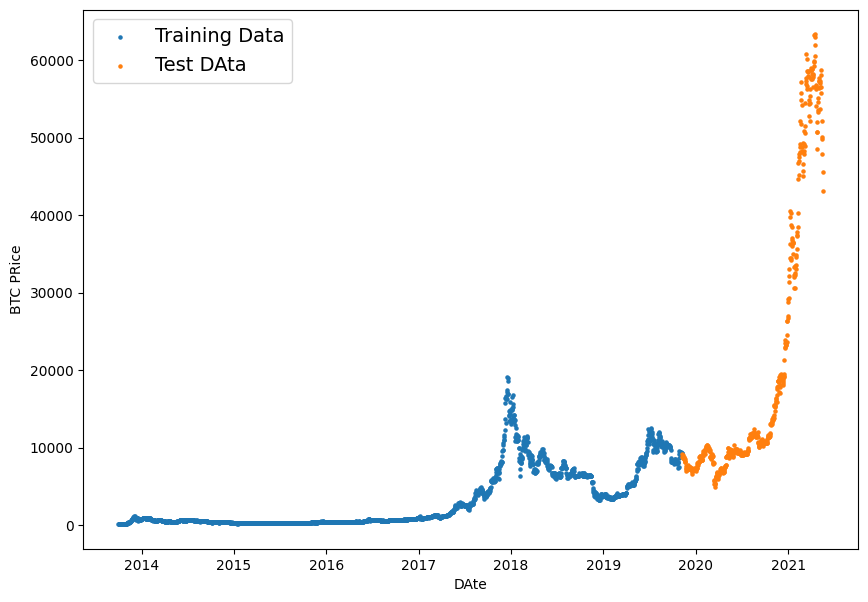

In [14]:
#Let's plot the wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Training Data")
plt.scatter(X_test, y_test, s=5, label="Test DAta")
plt.xlabel("DAte")
plt.ylabel("BTC PRice")
plt.legend(fontsize=14)
plt.show();

###Creating a plot funtion

In [15]:
#Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps)
  Parameters
  ----------
  timesteps : array of timesteps values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps)
  end : where to end the plot (setting a value will index from end of timesteps)
  label : label to show on plot about values
  """
  #Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

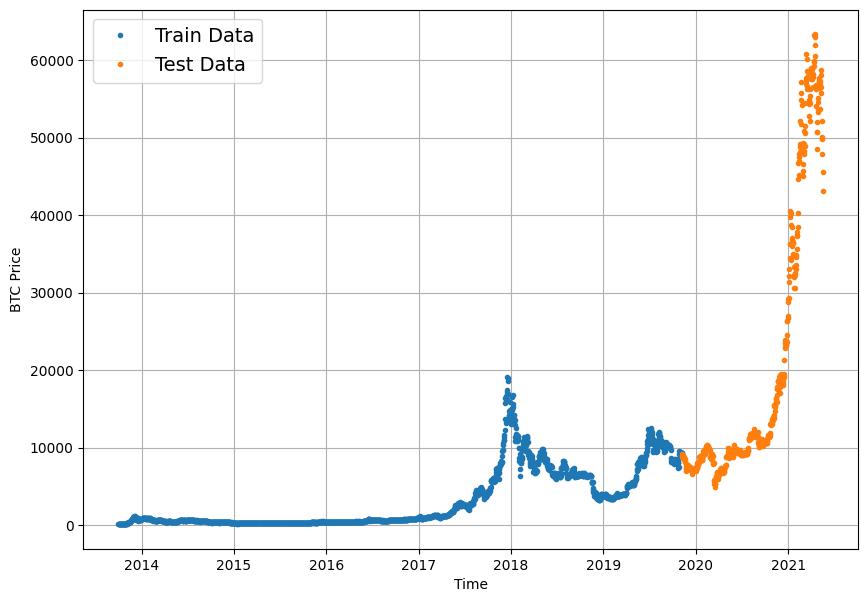

In [16]:
#Try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_train, values=y_train, label="Train Data")
plot_time_series(timesteps = X_test, values=y_test, label="Test Data")


###Modelling Experiments

We can build almost any kind of model for our problems as long as the data i/ps and o/ps are formatted clearly

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.

* horizon = number of timesteps to predict into future
* window = number of timesteps from past used to predict horizon

###Model 0:Naive Forecast(baseline)



In [17]:
y_test[-10:]

array([[58788.20967893],
       [58102.19142623],
       [55715.54665129],
       [56573.5554719 ],
       [52147.82118698],
       [49764.1320816 ],
       [50032.69313676],
       [47885.62525472],
       [45604.61575361],
       [43144.47129086]])

In [18]:
#Create a naive forecast
naive_forecast = y_test[:-1] #Naive FOrecast equals every value excluding the last
naive_forecast[:10], naive_forecast[-10:]# View first 10 and last 10

(array([[9226.48582088],
        [8794.35864452],
        [8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102],
        [8656.97092235],
        [8500.64355816],
        [8469.2608989 ]]),
 array([[57107.12067189],
        [58788.20967893],
        [58102.19142623],
        [55715.54665129],
        [56573.5554719 ],
        [52147.82118698],
        [49764.1320816 ],
        [50032.69313676],
        [47885.62525472],
        [45604.61575361]]))

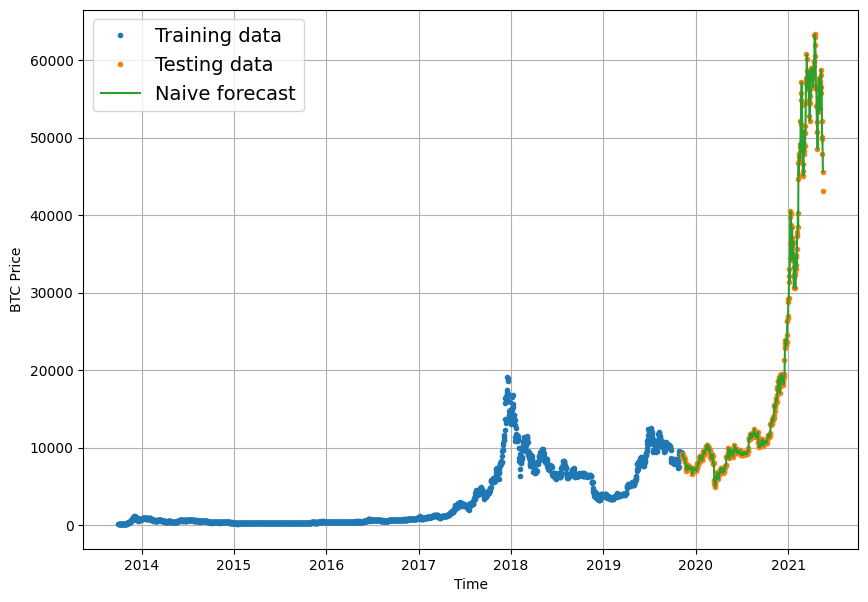

In [19]:
#Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Training data")
plot_time_series(timesteps=X_test, values=y_test, label="Testing data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-',label="Naive forecast")

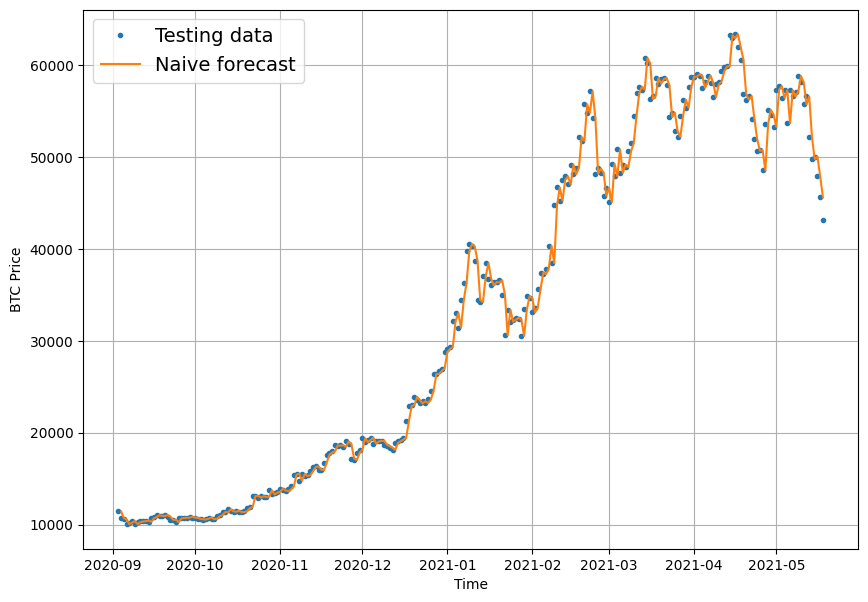

In [20]:
plt.figure(figsize=(10,7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset,label="Testing data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-',start=offset,label="Naive forecast")

In [21]:
len(y_test)

558

###Evaluating a time series model


In [22]:
# Let's get tensorflow
import tensorflow as tf

In [23]:
# MASE implemented courtsey of skitime
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  #Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae/mae_naive_no_season

In [24]:
import tf_keras as keras
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  #y_true = tf.cast(y_true, dtype=tf.float32)
  #y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': np.float64(567.9802273457541),
 'mse': np.float64(1147547.1250238959),
 'rmse': np.float64(567.9802273457541),
 'mape': np.float64(2.5165249299822663),
 'mase': np.float64(0.9995699939182624)}

In [26]:
#Find average price of Bitcopin in test Dataset
tf.reduce_mean(y_test).numpy()

np.float64(20056.632963737222)

###Format Data Part 2:Windowing Dataset
Why do we window??

Windowing is a method to turn a time series daatset into **supervised learning problem**

FOr example for a univariate time series, windowing for one week(window=7) to predict the next single value(horizon=1) might look like:

Window for one week (univariate time series)

[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]

Or for the price of bitcoin, it'd look like:

Window for one week with the target of prediciting the next day




In [27]:
HORIZON = 1
WINDOW_SIZE = 7

##NOw we'll wirte a fucntion to take in an array and tur it into a window and horizon

In [28]:
#Create fucntion to label windowed data
def get_labelled_windows(x , horizon=1):
  """
  Creates labels for windowed dataset

  E.g. if horizon = 1(default)
  Input: [1,2,3,4,5,6] -> Ouput: ([1,2,3,4,5],[6])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")


Window: [1 2 3 4 5 6 7] -> Label: 8


In [30]:
#Create fucntion to view NumPy arrays as Windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array of sequential windows of windows_size
  """

  #1. Create a window of specific window_size (add the horizon in the end for later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  #print(f"Window step:\n {window_step}")

  #2. Create a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T

  #3. Index on the target array
  windowed_array = x[window_indexes]

  #4. Get the labelled windows
  windows,labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the forst 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> label:{full_labels[i]}")

Window: [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]] -> label:[[123.033]]
Window: [[125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]
 [123.033  ]] -> label:[[124.049]]
Window: [[108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]
 [123.033  ]
 [124.049  ]] -> label:[[125.96116]]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [[58788.20967893]
 [58102.19142623]
 [55715.54665129]
 [56573.5554719 ]
 [52147.82118698]
 [49764.1320816 ]
 [50032.69313676]] -> Label: [[47885.62525472]]
Window: [[58102.19142623]
 [55715.54665129]
 [56573.5554719 ]
 [52147.82118698]
 [49764.1320816 ]
 [50032.69313676]
 [47885.62525472]] -> Label: [[45604.61575361]]
Window: [[55715.54665129]
 [56573.5554719 ]
 [52147.82118698]
 [49764.1320816 ]
 [50032.69313676]
 [47885.62525472]
 [45604.61575361]] -> Label: [[43144.47129086]]


#Turning windows into training and test sets


In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = tf.cast(labels[split_size:],dtype=tf.float32)
  return train_windows, test_windows, train_labels, test_labels

In [35]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels),

(2224, 2224, 556, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[[123.65499],
         [125.455  ],
         [108.58483],
         [118.67466],
         [121.33866],
         [120.65533],
         [121.795  ]],
 
        [[125.455  ],
         [108.58483],
         [118.67466],
         [121.33866],
         [120.65533],
         [121.795  ],
         [123.033  ]],
 
        [[108.58483],
         [118.67466],
         [121.33866],
         [120.65533],
         [121.795  ],
         [123.033  ],
         [124.049  ]],
 
        [[118.67466],
         [121.33866],
         [120.65533],
         [121.795  ],
         [123.033  ],
         [124.049  ],
         [125.96116]],
 
        [[121.33866],
         [120.65533],
         [121.795  ],
         [123.033  ],
         [124.049  ],
         [125.96116],
         [125.27966]]]),
 array([[[123.033  ]],
 
        [[124.049  ]],
 
        [[125.96116]],
 
        [[125.27966]],
 
        [[125.9275 ]]]))

#Make a modelling checkpoint

In [37]:
import os

# Create a fiunction to implement a ModelCheckpoint callback with a specific
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name) + ".keras",
                                            verbose=0,
                                            save_best_only=True)

#Model 1:Dense model(window=7,horizon=1)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import tf_keras as keras

#Set the random seed
tf.random.set_seed(42)

#Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear")

], name="model_1_dense")

#COmpile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

#Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 2518.2344 - mae: 2518.2344 - val_loss: 11944.8643 - val_mae: 11944.8643
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1652.7104 - mae: 1652.7107 - val_loss: 6469.3970 - val_mae: 6469.3965
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 788.0858 - mae: 788.0858 - val_loss: 1404.9303 - val_mae: 1404.9304
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 232.9093 - mae: 232.9093 - val_loss: 1242.6228 - val_mae: 1242.6227
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 213.8334 - mae: 213.8334 - val_loss: 1243.2344 - val_mae: 1243.2343
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 209.8219 - mae: 209.8219 - val_loss: 1199.9850 - val_mae: 1199.9849
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 207.6428 - mae: 207.6428 - val_loss: 1200.8948 - val_mae: 1200.8948
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 207.6171 - mae: 207.6171 - val_loss: 1206.6

In [39]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 589.9119 - mae: 589.9119


[1202.286865234375, 1202.286865234375]

In [40]:
#Load the best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 589.2612 - mae: 589.2611


[1199.33447265625, 1199.33447265625]

#Make forecast with the model


In [41]:
def make_preds(model,input_data):
  """
  Uses model to make predictions on input_data


  Parameters
  ----------------------
  model:trained model
  input_data: winodwed input data (same kind of data model was trained on)

  Returns model predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [42]:
#Make predictions using model_1 on the test_dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(556,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[9312.023, 9223.353, 9390.922, 9347.803, 9356.974, 9247.475,
         8814.426],
        [9223.353, 9390.922, 9347.803, 9356.974, 9247.475, 8814.426,
         8818.117],
        [9390.922, 9347.803, 9356.974, 9247.475, 8814.426, 8818.117,
         9101.865],
        [9347.803, 9356.974, 9247.475, 8814.426, 8818.117, 9101.865,
         8731.424],
        [9356.974, 9247.475, 8814.426, 8818.117, 9101.865, 8731.424,
         8780.888],
        [9247.475, 8814.426, 8818.117, 9101.865, 8731.424, 8780.888,
         8769.492],
        [8814.426, 8818.117, 9101.865, 8731.424, 8780.888, 8769.492,
         8676.745],
        [8818.117, 9101.865, 8731.424, 8780.888, 8769.492, 8676.745,
         8520.084],
        [9101.865, 8731.424, 8780.888, 8769.492, 8676.745, 8520.084,
         8488.635],
        [8731.424, 8780.888, 8769.492, 8676.745, 8520.084, 8488.635,
         8556.858]], dtype=float32)>)

In [43]:
#Evaluate the preds
model_1_results = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)
model_1_results

{'mae': np.float32(17044.926),
 'mse': np.float32(611103300.0),
 'rmse': np.float32(17093.258),
 'mape': np.float32(111.869446),
 'mase': np.float32(29.943214)}

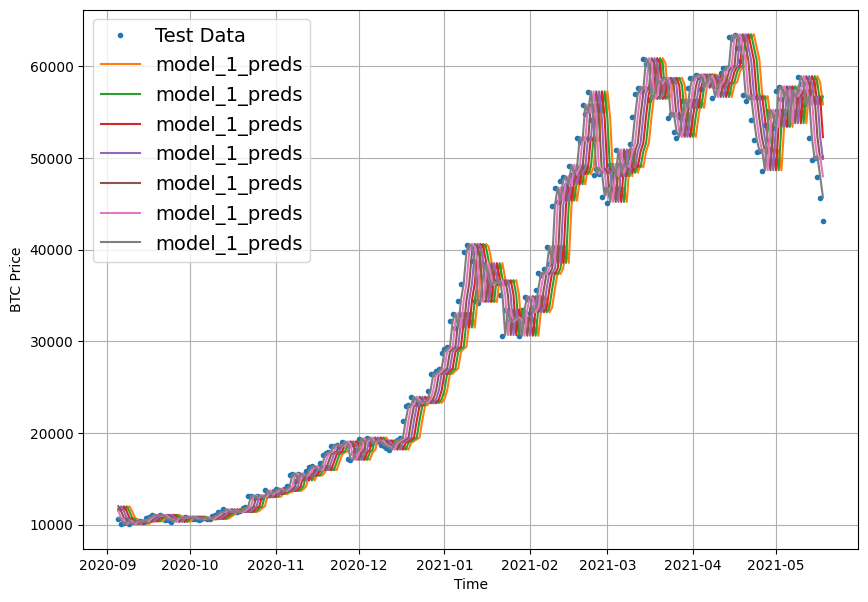

In [44]:
offset = 300
plt.figure(figsize=(10,7))
#Account for the test_window offset and index into test_labels to ensure correct plot
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")


###Model 2:Dense(window=30, horizon=1)

In [45]:
HORIZON = 1
WINDOW_SIZE = 30

In [46]:
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [47]:
tf. random.set_seed(42)

#Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

#Compile the model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [48]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 597.1534


1221.9627685546875

In [49]:
#Load in the best performing moidel
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 590.7712


1192.2550048828125

In [50]:
#Get forecast predicitons
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [51]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels,axis=1), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': np.float32(1192.255),
 'mse': np.float32(5005163.5),
 'rmse': np.float32(1359.5992),
 'mape': np.float32(5.2940702),
 'mase': np.float32(2.0944617)}

In [52]:
naive_results

{'mae': np.float64(567.9802273457541),
 'mse': np.float64(1147547.1250238959),
 'rmse': np.float64(567.9802273457541),
 'mape': np.float64(2.5165249299822663),
 'mase': np.float64(0.9995699939182624)}

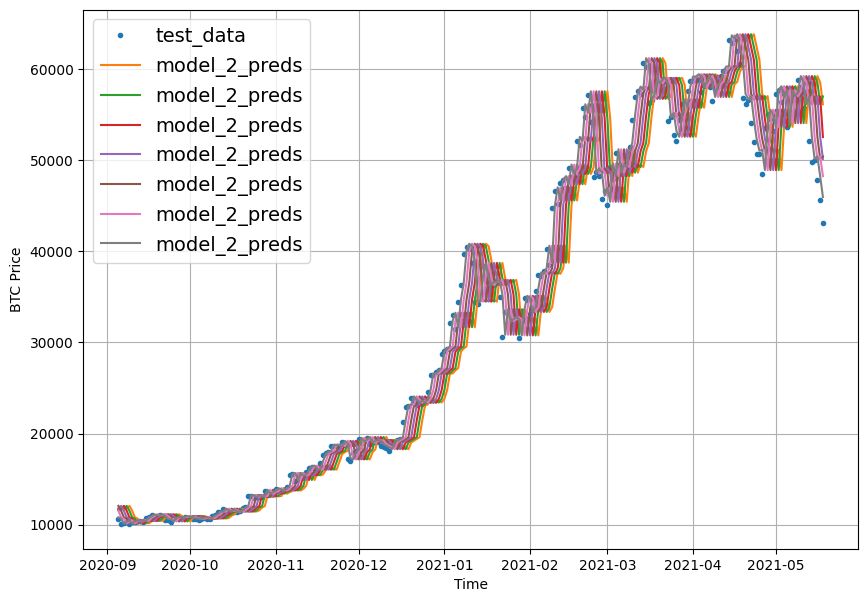

In [53]:
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")



#Model 3: Dense(window=30,horizon=7)

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Flatten(),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 656.5632


1297.5772705078125

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 637.3320


1259.580322265625

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9168.876, 9224.21 , 9265.42 , 9503.961, 9445.181, 9531.427,
        9295.416],
       [8821.627, 8857.055, 8887.303, 9214.816, 9197.202, 9287.033,
        9067.909],
       [8609.914, 8677.248, 8765.926, 9063.534, 9039.994, 9149.873,
        8948.305],
       [8731.965, 8868.031, 8972.079, 9292.372, 9217.841, 9252.281,
        9067.142],
       [8662.822, 8813.147, 8926.186, 9231.503, 9176.021, 9151.339,
        8884.971]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': np.float32(1259.5803),
 'mse': np.float32(5375079.5),
 'rmse': np.float32(1446.5709),
 'mape': np.float32(5.700449),
 'mase': np.float32(2.2413526)}

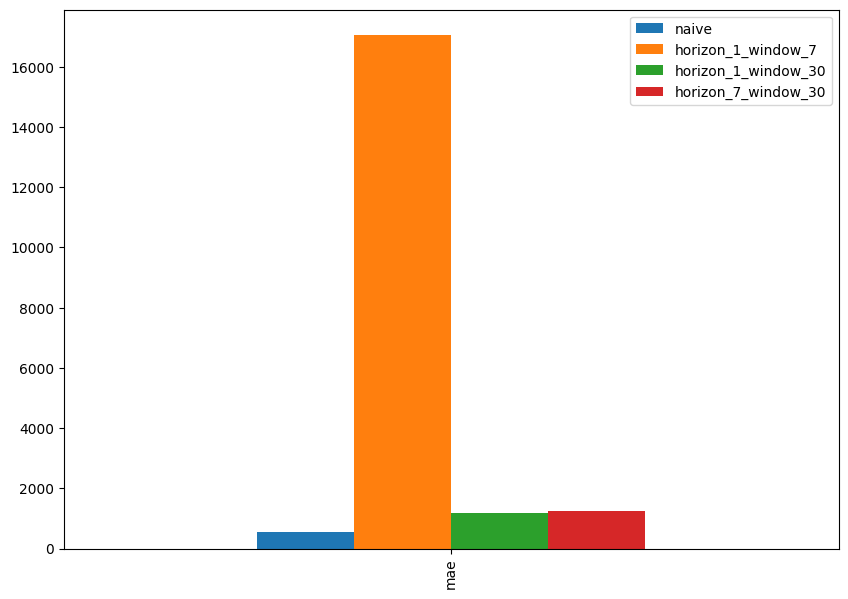

In [59]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


#Model 4: Conv1D

In [60]:
HORIZON = 1
WINDOW_SIZE = 7

In [61]:
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [62]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [63]:
train_windows[0].shape

(7, 1)

In [64]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")


Original shape: (7, 1)
Expanded shape: (7, 1, 1)
Original values with expanded shape:
 [[[123.65499]]

 [[125.455  ]]

 [[108.58483]]

 [[118.67466]]

 [[121.33866]]

 [[120.65533]]

 [[121.795  ]]]


In [65]:

tf.random.set_seed(42)
train_windows = train_windows.squeeze(axis=-1) # Remove the extra dimension at the end
test_windows = test_windows.squeeze(axis=-1)
# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
   # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(expand_dims_layer(train_windows),
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(expand_dims_layer(test_windows), test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [66]:
model_4.summary()

Model: "model_4_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [67]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D.keras")
model_4.evaluate(expand_dims_layer(test_windows), test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 283.7260


568.091552734375

In [68]:
model_4_preds = make_preds(model_4, expand_dims_layer(test_windows))
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8870.646, 8781.691, 9005.758, 8776.719, 8741.739, 8733.809,
       8679.642, 8520.49 , 8454.969, 8517.466], dtype=float32)>

In [69]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': np.float32(568.09155),
 'mse': np.float32(1172894.9),
 'rmse': np.float32(1083.0027),
 'mape': np.float32(2.5432105),
 'mase': np.float32(0.9979795)}

##MOdel 5: RNN(LSTM)

In [70]:
tf.random.set_seed(42)

#Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Reshape((WINDOW_SIZE, 1))(inputs)  # Add the channel dimension
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")


#Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [71]:
#Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM.keras")
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 330.8639


657.6431884765625

In [72]:
#Make predictions with our LSTM Model
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9102.828, 8886.799, 8974.2  , 8920.318, 8775.967, 8803.424,
       8763.706, 8634.527, 8537.266, 8551.271], dtype=float32)>

In [73]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': np.float32(657.64325),
 'mse': np.float32(1510869.5),
 'rmse': np.float32(1229.1743),
 'mape': np.float32(2.952953),
 'mase': np.float32(1.155297)}

###Make a multi variate time seires


In [74]:
bitcoin_prices.head()

,Closing Price (USD)
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [75]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

#Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [76]:

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [77]:
bitcoin_prices.index[8]

Timestamp('2013-10-09 00:00:00')

In [78]:
bitcoin_prices.head(10)

,Closing Price (USD)
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


In [79]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

#Set values of block_reward column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block = bitcoin_prices_block.rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


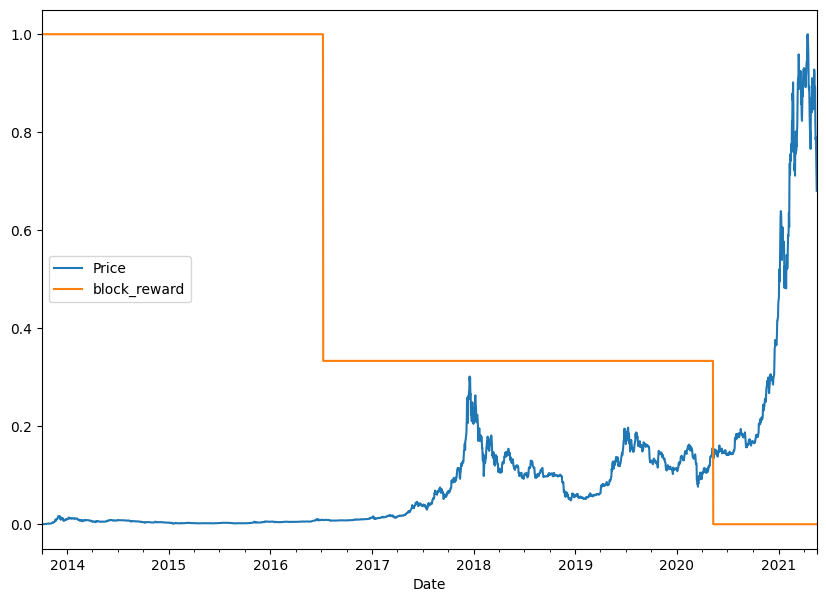

In [80]:
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [81]:
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


#Making a windowed dataset with pandas

In [82]:
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

#Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [84]:
# Let's create X and y, remove the NaN
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [85]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


#Model 6: Dense(multivariate time series)

In [86]:
X_train

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', ...,
       '2019-11-05T00:00:00.000000000', '2019-11-06T00:00:00.000000000',
       '2019-11-07T00:00:00.000000000'], dtype='datetime64[ns]')

In [91]:
import numpy as np

# Convert X_train and X_test to Pandas DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Now apply select_dtypes to the DataFrames
X_train_num = X_train_df.select_dtypes(include=np.number).astype(np.float32)
X_test_num = X_test_df.select_dtypes(include=np.number).astype(np.float32)

In [92]:
tf.random.set_seed(42)


model_6 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())



In [94]:
# Convert datetimes to numbers
import numpy as np



# Now use these numerical versions in your model training
model_6.fit(X_train_num, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test_num, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3132.1182 - val_loss: 20056.6152
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3132.0999 - val_loss: 20056.5977
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3132.0818 - val_loss: 20056.5781
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3132.0640 - val_loss: 20056.5625
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3132.0457 - val_loss: 20056.5449
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3132.0281 - val_loss: 20056.5234
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3132.0098 - val_loss: 20056.5078
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3131.9919 - val_loss: 20056.4883
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3131.9741 - val_loss: 20056.4727
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3131.9558 - val_loss: 20056.4551
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3131.9377 - v

#Model 7: N-Beats Algorithm

In [95]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,#the constructor takes all the hyperparamters for the layers,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers) ]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear",name="theta")
  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast,forecast

In [96]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [97]:
# Create dummy i/ps
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1,axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [98]:
#Pass dummy inputs to dummy NBeatsBlock Layer
backcast,forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"backcast: {tf.squeeze(backcast.numpy())}")
print(f"forecast: {tf.squeeze(forecast.numpy())}")

backcast: [-0.8020381  -0.07225956 -1.8399198  -0.71868455  0.8372504  -0.11219901
  0.66497195]
forecast: 0.979048490524292


#preparing data for the N-Beats algorithm using tf.data

In [102]:
#In cell ipython-input-99-ab80bbc601c8
#bitcoin_prices.dropna().rename(columns={"Closing Price (USD)": "Price"}, inplace=True) #inplace=True is ingored here
bitcoin_prices = bitcoin_prices.dropna().rename(columns={"Closing Price (USD)": "Price"}) #Remove inplace=True and reassign
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [103]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [104]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [105]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#Setting up hyperpaarmters for N-Beats ALgo

In [106]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE


(7, 8)

#getting ready for residual connection

In [107]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

#Subtract
subtracted = layers.subtract([tensor_1,tensor_2])

#Add
added = layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [108]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])



Epoch 237: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 351: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 451: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 1min 44s, sys: 14.1 s, total: 1min 58s
Wall time: 4min 2s


In [109]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 575.5804 - mae: 575.5804 - mse: 1161206.1250


[575.5803833007812, 575.5803833007812, 1161206.125]

In [110]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8811.139, 8764.446, 8974.351, 8711.937, 8806.428, 8734.445,
       8591.631, 8517.631, 8455.903, 8483.87 ], dtype=float32)>

In [111]:
# Evaluate N_beats model predictions
model_7_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_7_preds)
model_7_results


{'mae': np.float32(575.5804),
 'mse': np.float32(1161206.0),
 'rmse': np.float32(1077.5927),
 'mape': np.float32(2.6263337),
 'mase': np.float32(1.0111353)}

#Plotting the N-Beasts architecture we've created


In [112]:
from tensorflow.keras.utils import plot_model
plot_model(model_7, show_shapes=True)

In [114]:
model_7.save(model_7.name + ".keras") # Add the .keras extension

#Model 8: Creating an ensemble (stacking different models together)

#Construction and fitting an ensemble of models (using different loss functions)

In [115]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [116]:
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 812: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 227: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 327: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 162: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 262: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 233: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 481: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 581: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

#Making Predicitions with an ensemble model

In [117]:
def make_ensemble_preds(ensemble_models, data):
  """
  Makes predictions using a list of ensemble models and returns them.

  Args:
      ensemble_models (list): A list of trained TensorFlow models.
      data (tf.data.Dataset): The dataset to make predictions on.

  Returns:
      tf.Tensor: A tensor containing the ensemble predictions.
  """
  ensemble_preds = []  # Initialize ensemble_preds as an empty list
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [118]:
ensemble_preds = make_ensemble_preds(ensemble_models = ensemble_models,
                                     data = test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8815.876,  8736.434,  9115.958, ..., 49935.184, 48007.637,
        46075.62 ],
       [ 8776.319,  8776.347,  9011.784, ..., 50136.84 , 48272.496,
        46133.04 ],
       [ 8823.412,  8801.728,  9043.925, ..., 49939.85 , 48469.14 ,
        46513.62 ],
       ...,
       [ 8829.638,  8782.96 ,  9083.507, ..., 49475.203, 48888.84 ,
        45228.07 ],
       [ 8772.436,  8717.463,  8986.73 , ..., 49676.56 , 48365.117,
        45733.33 ],
       [ 8769.856,  8746.328,  9021.155, ..., 49832.875, 48430.992,
        45495.156]], dtype=float32)>

In [119]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds,axis=0))
ensemble_results

{'mae': np.float32(568.9255),
 'mse': np.float32(1155737.0),
 'rmse': np.float32(1075.0521),
 'mape': np.float32(2.5649602),
 'mase': np.float64(nan)}

In [120]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)


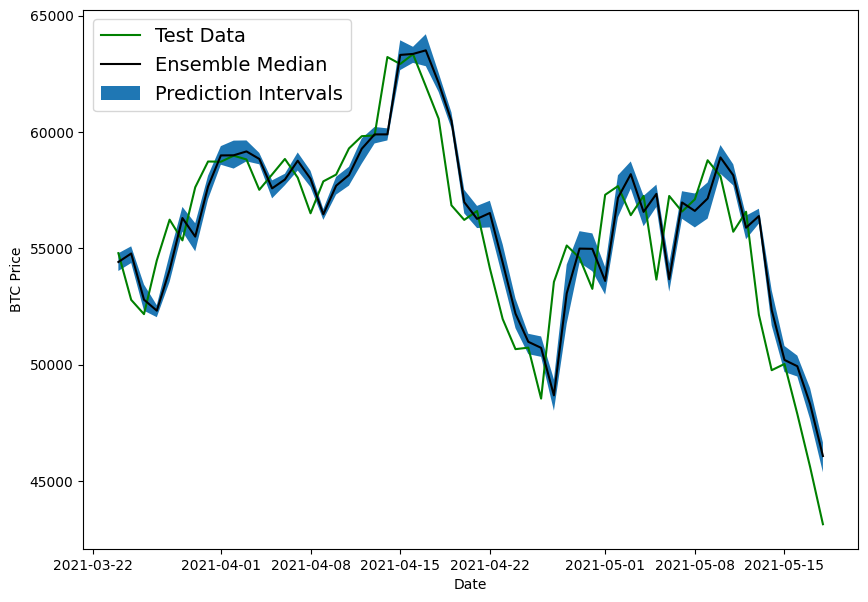

In [121]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);


#Model 9: Train a model on the full historical data to make preidcitions into future

In [122]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [123]:
X_all = bitcoin_prices_windowed.drop(["Price","block_reward"],axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [124]:
feature_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((feature_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [135]:
tf.random.set_seed(42)

#create model
model_9 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 4023.3716
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2799.0183
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1691.6636
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 638.5790
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 451.0494
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 772.9113
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 617.3156
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 261.1893
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 326.0810
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 412.2859
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 276.0071
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 215.8828
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 287.9785
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 219.2053
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 209.4900

#Make predictions on the future

In [126]:
INTO_FUTURE = 14

In [127]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(into_future):

    future_pred = model.predict(tf.expand_dims(last_window,axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [128]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55829.29296875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55829.29296875] -> Prediction: 50748.2734375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55829.29296875 50748.2734375 ] -> Prediction: 49585.55078125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55829.29296875 50748.2734375  49585.55078125] -> Prediction: 48038.26171875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55829.29296875
 50748.2734375  49585.55078125 48038.26171875] -> Prediction: 48437.89453125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49

In [129]:
future_forecast[:10]

[np.float32(55829.293),
 np.float32(50748.273),
 np.float32(49585.55),
 np.float32(48038.26),
 np.float32(48437.895),
 np.float32(45999.34),
 np.float32(47848.34),
 np.float32(54132.094),
 np.float32(49885.945),
 np.float32(48703.68)]

#Plot Future forecast

In [130]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future,"D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [131]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [132]:
next_time_steps = get_future_dates(start_date=last_timestep,
                                  into_future=INTO_FUTURE)
next_time_steps


array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [133]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast


(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55829.293, 50748.273, 49585.55 , 48038.26 , 48437.895,
        45999.34 , 47848.34 , 54132.094, 49885.945, 48703.68 , 47788.52 ,
        48860.387, 47228.85 , 50105.227], dtype=float32))

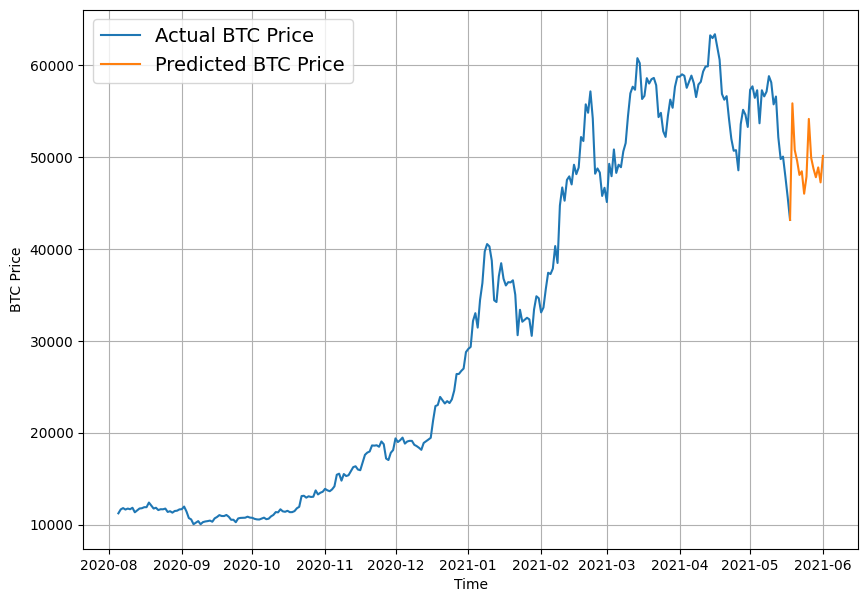

In [134]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")


#Compare Model

In [142]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              #"model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              }).T
model_results.head(10)


,mae,mse,rmse,mape,mase
naive_model,567.980227,1.147547e+06,567.980227,2.516525,0.999570
model_1_dense_w7_h1,17044.925781,6.111033e+08,17093.257812,111.869446,29.943214
model_2_dense_w30_h1,1192.255005,5.005164e+06,1359.599243,5.294070,2.094462
model_3_dense_w30_h7,1259.580322,5.375080e+06,1446.570923,5.700449,2.241353
model_4_CONV1D,568.091553,1.172895e+06,1083.002686,2.543211,0.997980
model_5_LSTM,657.643250,1.510870e+06,1229.174316,2.952953,1.155297
model_8_NBEATs,575.580383,1.161206e+06,1077.592651,2.626334,1.011135
model_9_ensemble,568.925476,1.155737e+06,1075.052124,2.564960,NaN


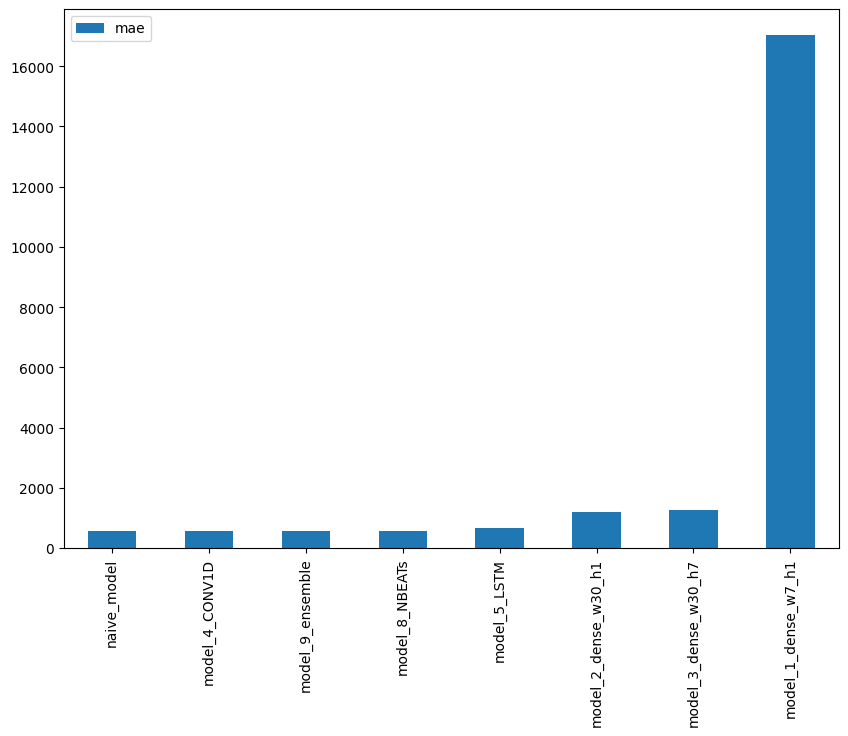

In [143]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");